Q1) What are the parameters of batchnorm? What information do you need to train the parameters?  

A1) $ \frac{X - \mu}{\sigma} * \gamma + \beta $, in which $\gamma$ and $\beta$ are optimized using training data (i.e. parameter) and $\mu$ and $\sigma$ attained from data.

Q2) Why do we use 'exponentially weighted moving average' (chain of linear interpolation) of training data in inference time? In other words, why can't we use one batch of training set's mean and variance in inference time?  
A2) When we get a totally different type of image at inference time, we can not fairly access/evaluate the parameters since attained mean/variance of one training data could be irrevant to validation/test data.

In [1]:
!git clone https://github.com/fastai/course-v3/

Cloning into 'course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.03 MiB | 30.80 MiB/s, done.
Resolving deltas: 100% (3249/3249), done.


In [1]:
%cd /content/course-v3/nbs/dl2/
%load_ext autoreload
%autoreload 2
%matplotlib inline
from exp.nb_06 import *

/content/course-v3/nbs/dl2


In [47]:
def get_data():
    # path = datasets.download_data(MNIST_URL, ext='.gz')
    path = '/content/mnist.pkl.gz'
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

- get data and transform those to regularized size
- dataset class, which enables slicing and length information
- databunch instance, which gives 1) dataloader 2) number of class
    1. dataloader
        - generate training data in a random order (when shuffle=True)
        - in case tensors don't have same length, pad first or last (e.g. pytorch [pad_packed_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html))
- callback functions
    - recorder which records learning rate and loss
    - avgstats which records total loss and batch count
    - cuda : convert to gpu before batch
    - unflatten image

- define convolution channels 


In [48]:
x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)

train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1

loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        # CudaCallback,
        partial(BatchTransformXCallback, view_tfm(1, 28, 28))]

nfs = [8, 16, 32, 64, 64]
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

%time run.fit(2, learn)

train: [0.32559931640625, tensor(0.9072)]
valid: [0.23114140625, tensor(0.9276)]
train: [0.126513701171875, tensor(0.9621)]
valid: [0.13853365478515625, tensor(0.9545)]
CPU times: user 29.2 s, sys: 466 ms, total: 29.7 s
Wall time: 15.2 s


🎮 Q3: Implement customized batch norm, and plot activations’ mean and std.
- Caution: in train uses batches mean and variance while inference time it uses exponentially weighted moving average
- Caution: batch norm broadcasts tensor thorough batch data. so that dimension size of normalizing parameter differs depending on types of normalization.

In [31]:
# customized batchnorm
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps

        self.mult = nn.Parameter(torch.ones(nf, 1, 1))
        self.add  = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars', torch.ones(1, nf, 1, 1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))

    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
    def forward(self, x):
        if self.training:
            with torch.no_grad(): # TODO: where and where not we need this?
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x - m) / (v+self.eps).sqrt()
        return x * self.mult + self.add

In [32]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias = not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [49]:
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        # actualy initialization happens here
        f(m.weight, a=0.1)
        # when bias exist (i.e. no batchnorm) make sure it's zero
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func) 

- plot activations

In [35]:
import inspect
print(inspect.getsource(append_stats))
print(inspect.getsource(Hooks))
print(inspect.getsource(Hook))

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    if mod.training:
        means.append(outp.data.mean())
        stds .append(outp.data.std())

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)

    def remove(self):
        for h in self: h.remove()

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()



In [40]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): GeneralRelu()
    (2): BatchNorm()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=64, out_features=10, bias=True)
)

train: [0.27959453125, tensor(0.9112)]
valid: [0.1603647216796875, tensor(0.9494)]


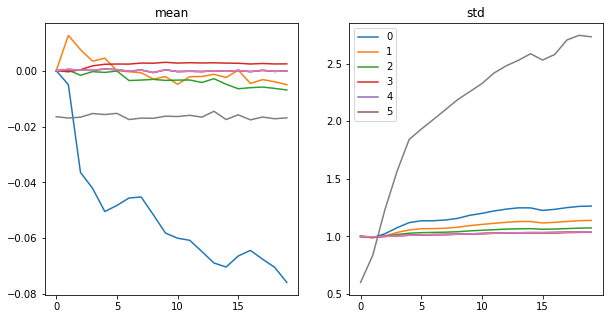

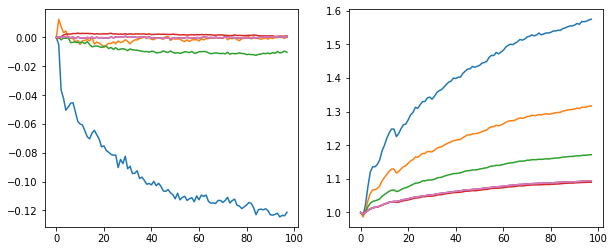

In [56]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,5))
    ax0.title.set_text("mean")
    ax1.title.set_text("std")
    #  draw first 20 batches
    for hook in hooks:
        mean, std = hook.stats
        ax0.plot(mean[:20])
        ax1.plot(std[:20])
    plt.legend(range(6))
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

train: [0.2757481640625, tensor(0.9150)]
valid: [0.42459921875, tensor(0.8661)]


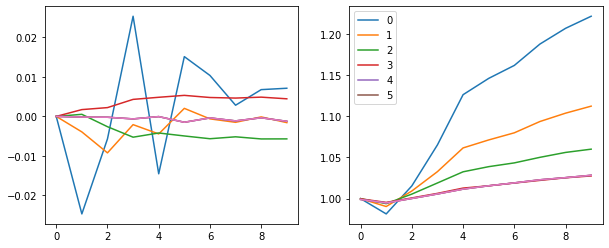

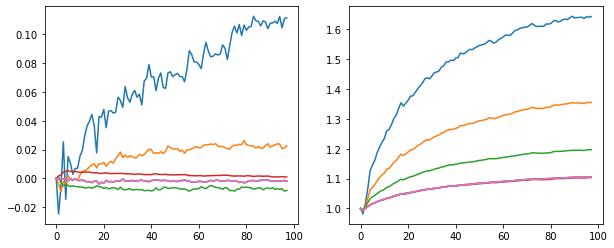

In [57]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
       h.remove()        

🎮 Q4: Use built-in batchnorm of pytorch

In [58]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias = not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [62]:
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)
run.fit(1, learn)

train: [0.2351971875, tensor(0.9285)]
valid: [0.12535440673828124, tensor(0.9620)]


🎮 Q5: Add scheduler and train

In [64]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.7, 2), sched_lin(2, 0.2)])

In [69]:
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs + [partial(ParamScheduler, 'lr', sched)])
run.fit(1, learn)

train: [0.25600046875, tensor(0.9201)]
valid: [0.07083250732421875, tensor(0.9802)]


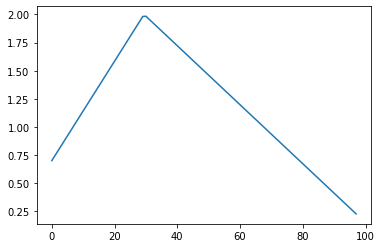

In [70]:
run.recorder.plot_lr()



📝 Q6: Explain difference between batchnorm and layernorm. Implement Layernorm class.

📝 🎮 Q7: Implement InstanceNorm class. Why do you think the model trained on instance norm can not be a classification model?

🎮 Q8: GroupNorm: initialize activation with N=20, channel = 6, height, width = 10 and 1) separate 6 channels into 3 groups 2) separate 6 channels into 6 groups (instancenorm) 3) put all 6 channels into as signle group (layernorm)

📝 🎮 Q9: Fastai introduces RunningBatchNorm class to be used in small batch cases. Implement it and write your opinion for what reason small batch size makes problem.